In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential,Model,model_from_json
from keras.layers import Dense,Conv2D,Activation,MaxPool2D,Flatten,Dropout,BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

In [3]:
data=pd.read_csv('fer2013.csv')

In [4]:
data.shape # Verinin kaç satır ve sütündan oluştuğunu görürüz.İnceleme-analiz

(35887, 3)

In [5]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
##Önİşleme Adımlarını gerçekleştiririz.

In [7]:
train_data=data[data.Usage=="Training"]

In [8]:
train_pixels=train_data.pixels.str.split(" ").tolist()

train_pixels=pd.DataFrame(train_pixels, dtype=int)
train_images=train_pixels.values
train_images=train_images.astype(np.float)

In [9]:
#Görüntüyü 48x48 piksel haline getirdik. Daha farklı boyutlara da getirebiliriz.
def show(img):
    show_image=img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

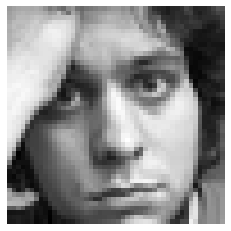

In [10]:
show(train_images[500])

Eğitim Kümemizdeki eşsiz sınıfları belirleriz.

In [11]:
train_labels_flat=train_data["emotion"].values.ravel()
train_labels_count=np.unique(train_labels_flat).shape[0]
print('Unique face expression count: ',train_labels_count)

Unique face expression count:  7


One Hot Encoding işlemi yaptırırız. Train için

In [12]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [13]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)
y_train = y_train.astype(np.uint8)
print(y_train.shape)

(28709, 7)


In [14]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


In [15]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

#test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık

(3589, 2304)


Test datasette img görebiliriz.

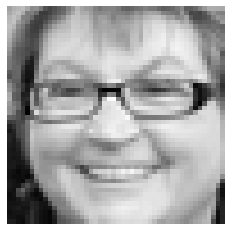

In [16]:
show(test_images[100])

Test Dataset için One Hot Encoding yaparız.

In [17]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


Yüz ifadelerinin gelmediğini plt kullanarak sisteme çekebiliriz.

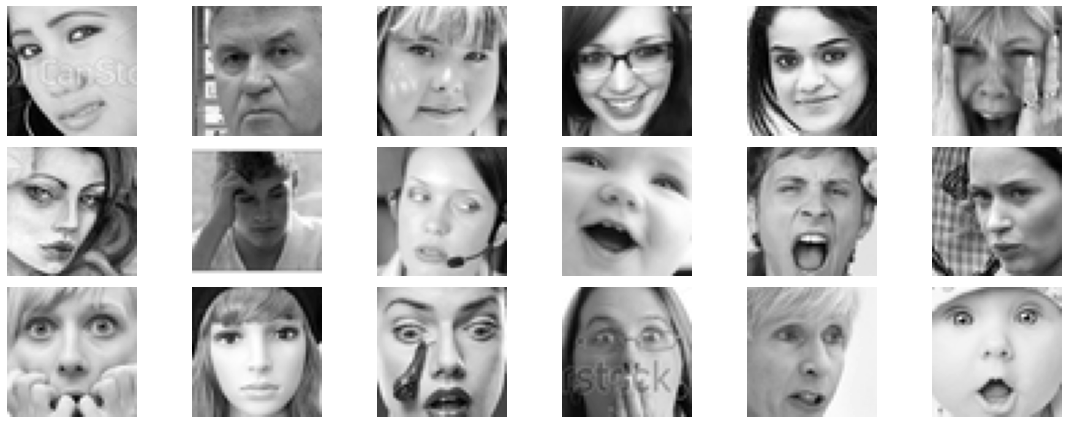

In [18]:
plt.figure(0, figsize=(16,6))
for i in range(1,19):
  plt.subplot(3, 6, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

MODEL- KATMANLARI OLUŞTURMA AŞAMASI

In [28]:
model = Sequential()

# KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# KATMAN

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

### KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


###  KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

###  KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.4)) 

### TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

### Çıkış katmanı

model.add(Dense(7))
model.add(Activation('softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

In [26]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [27]:
print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


In [29]:
#Best pt leri kaydederiz.
checkpointer = ModelCheckpoint(filepath='face_expression.h5', verbose=1, save_best_only=True)

epochs = 10
batchSize = 100

# modeli çalıştır

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)
                
model_json = model.to_json()
with open('face_expression.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/10
288/288 - 226s - loss: 1.5935 - accuracy: 0.3851 - val_loss: 1.4457 - val_accuracy: 0.4394

Epoch 00001: val_loss improved from inf to 1.44568, saving model to face_expression.h5
Epoch 2/10
288/288 - 237s - loss: 1.3294 - accuracy: 0.4904 - val_loss: 1.3305 - val_accuracy: 0.4943

Epoch 00002: val_loss improved from 1.44568 to 1.33054, saving model to face_expression.h5
Epoch 3/10
288/288 - 202s - loss: 1.2268 - accuracy: 0.5324 - val_loss: 1.2306 - val_accuracy: 0.5286

Epoch 00003: val_loss improved from 1.33054 to 1.23062, saving model to face_expression.h5
Epoch 4/10
288/288 - 181s - loss: 1.1610 - accuracy: 0.5566 - val_loss: 1.2191 - val_accuracy: 0.5380

Epoch 00004: val_loss improved from 1.23062 to 1.21915, saving model to face_expression.h5
Epoch 5/10
288/288 - 191s - loss: 1.1099 - accuracy: 0.5807 - val_loss: 1.1796 - val_accuracy: 0.5528

Epoch 00005: val_loss improved from 1.21915 to 1.17964, saving model to face_expression.h5
Epoch 6/10
288/288 - 194s - loss: 

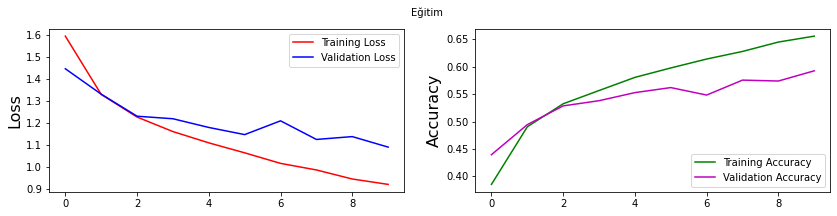

In [30]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()
#matplotlib kütüphanesini kullanarak elde ettiğimiz doğruluk vb. oranlarını tablo üzerinde karşılaştırabiliriz.

In [31]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [32]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [33]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [34]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

PrivateTest üzerindeki doğruluk durumu: [1.0570935010910034, 0.6018389463424683]


In [35]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

In [36]:
# best.pt weights üzerinden işlemleri yaparız. yükleme yap.
model_best = load_model('face_expression.h5')


In [55]:
#test_image=x_test_private[60] #eğer veri kümesinden bir görsel denemek isterseniz burada [] içine rastgele bir görsel numarası atayarak test edebilirsiniz!

image_path = "image/mutlu.jpg"

test_image_original = image.load_img(image_path) # orjinal renkli görüntü

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results


array([[0.10523587, 0.00281126, 0.11792166, 0.46572262, 0.08532222,
        0.08574856, 0.1372378 ]], dtype=float32)

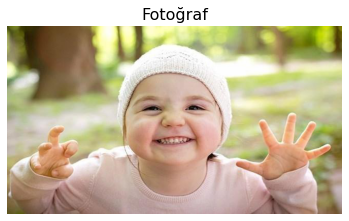

Sınıflandırma sonucu en yüksek oranla: mutlu


In [56]:
#Veri setimizde bulunan duygu durumlarını class verdik.
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4 

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# test resmimizi çizdirelim

plt.imshow(test_image_original)
plt.title('Fotoğraf', fontsize=16)
plt.axis('off')
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

